In [1]:
import numpy as np

class Kernel:
    def f(self, x1, x2):
        raise NotImplementedError()
    def f_mat(self, x):
        raise NotImplementedError()

class WhiteNoise(Kernel):
    def __init__(self, scale):
        self.scale = scale
    def f(self, x1, x2):
        return self.scale * (x1 == x2)
    def f_mat(self, x):
        return self.scale * np.eye(len(x))

class Constant(Kernel):
    def __init__(self, value):
        self.value = value
    def f(self, x1, x2):
        return self.value
    def f_mat(self, x):
        n = len(x)
        return self.value * np.ones((n, n))

class Linear(Kernel):
    def __init__(self, intercept):
        self.intercept = intercept
    def f(self, x1, x2):
        return (x1 - self.intercept) * (x2 - self.intercept)
    def f_mat(self, x):
        xs_minus_intercept = np.asarray(x) - self.intercept
        return np.outer(xs_minus_intercept, xs_minus_intercept)

class SquaredExponential(Kernel):
    def __init__(self, scale):
        self.scale = scale
    def f(self, x1, x2):
        return np.exp(-.5 * (x1 - x2) * (x1 - x2) / self.scale)
    def f_mat(self, x):
        dx = np.subtract.outer(x, x)
        return np.exp(-0.5 * dx * dx / self.scale)

class Periodic(Kernel):
    def __init__(self, scale, period):
        self.scale = scale
        self.period = period
    def f(self, x1, x2):
        freq = 2 * np.pi / self.period
        return np.exp((-1. / self.scale) * (np.sin(freq * abs(x1 - x2)))**2)
    def f_mat(self, x):
        freq = 2 * np.pi / self.period
        dx = np.subtract.outer(x, x)
        return np.exp((-1. / self.scale) * (np.sin(freq * abs(dx)))**2)

class Plus(Kernel):
    def __init__(self, K, H):
        self.K = K
        self.H = H
    def f(self, x1, x2):
        return self.K.f(x1, x2) + self.H.f(x1, x2)
    def f_mat(self, x):
        return self.K.f_mat(x) + self.H.f_mat(x)

class Times(Kernel):
    def __init__(self, K, H):
        self.K = K
        self.H = H
    def f(self, x1, x2):
        return self.K.f(x1, x2) * self.H.f(x1, x2)
    def f_mat(self, x):
        return self.K.f_mat(x) * self.H.f_mat(x)

def sigma_cp(x, location, scale):
    return .5 * (1 + np.tanh((location - x) / scale))

class ChangePoint(Kernel):
    def __init__(self, K, H, location, scale):
        self.K = K
        self.H = H
        self.location = location
        self.scale = scale
    def f(self, x1, x2):
        sigma_x1 = sigma_cp(x1, self.location, self.scale)
        sigma_x2 = sigma_cp(x2, self.location, self.scale)
        cov_K = sigma_x1 * self.K.f(x1, x2) * sigma_x2
        cov_H = (1 - sigma_x1) * self.H.f(x1, x2) * (1 - sigma_x2)
        return cov_K + cov_H
    def f_mat(self, x):
        change_x = sigma_cp(x, self.location, self.scale)
        sig_1 = np.outer(change_x, change_x)
        sig_2 = np.outer(1 - change_x, 1 - change_x)
        cov_K = self.K.f_mat(x)
        cov_H = self.H.f_mat(x)
        return sig_1 * cov_K + sig_2 * cov_H

In [2]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [3]:
xs = np.linspace(0, 10, 500)

0.001
0.4647841986652572
0.0939920809204717
0.47639757266249577
0.6848407182470919
0.27413911532256496
0.11581573644269162
0.14565628128886493
0.29732013465333224
0.4825751715713838
['0.95', '0.96', '-1.86', '-1.83']
['-0.09', '0.96', '-2.12', '-2.04']
['-1.15', '-1.06', '-0.23', '-0.24']
['-1.06', '-0.90', '-2.04', '-1.45']
['-0.42', '-1.56', '0.69', '0.94']
['1.84', '2.57', '0.63', '0.92']
['0.11', '0.34', '0.05', '0.24']
['-0.67', '-0.54', '0.76', '0.76']
['-1.23', '-0.69', '1.30', '0.67']
['-0.09', '-0.62', '1.45', '1.43']


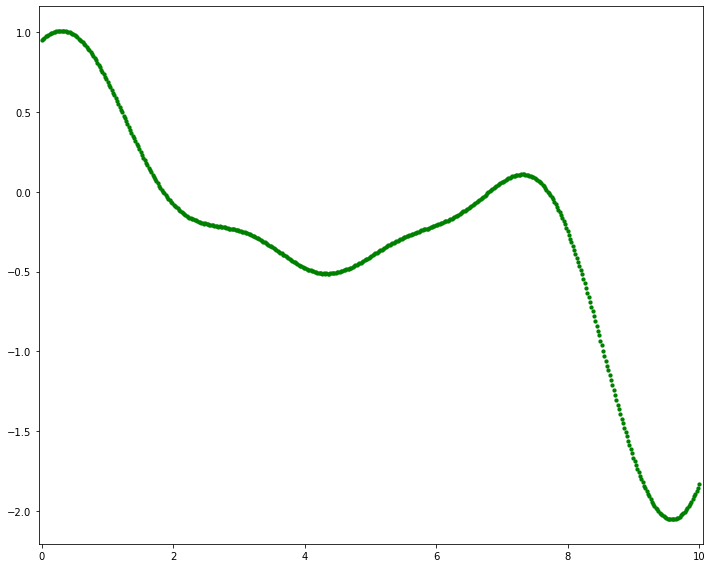

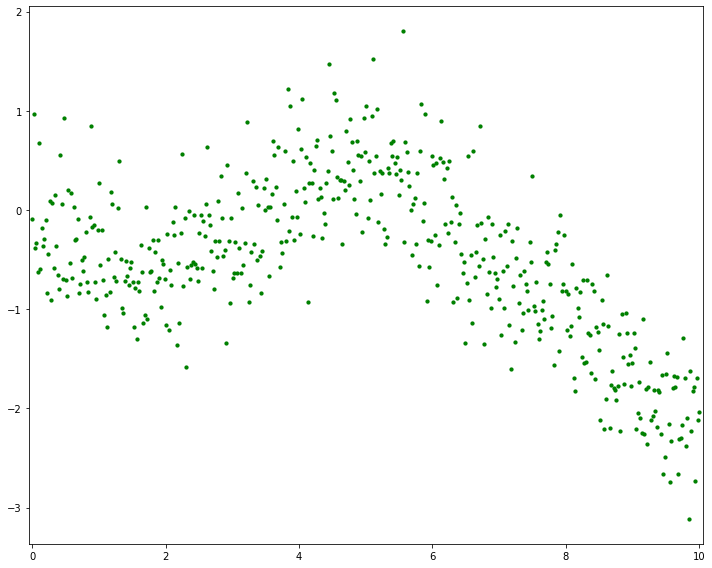

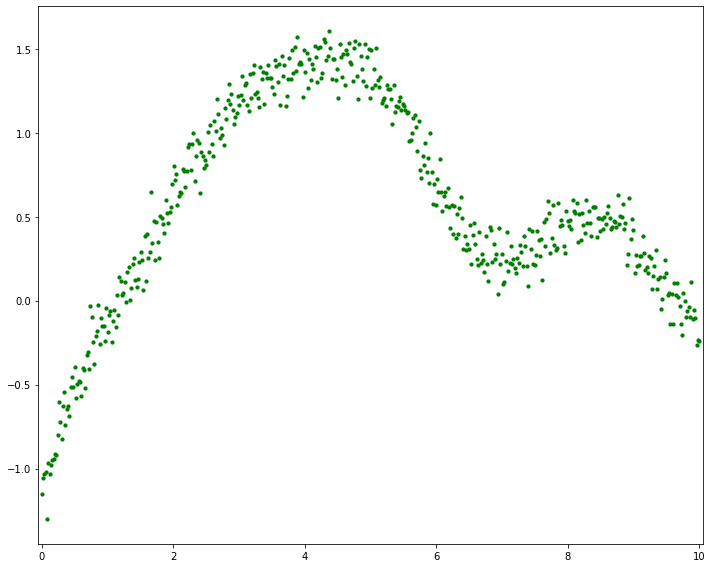

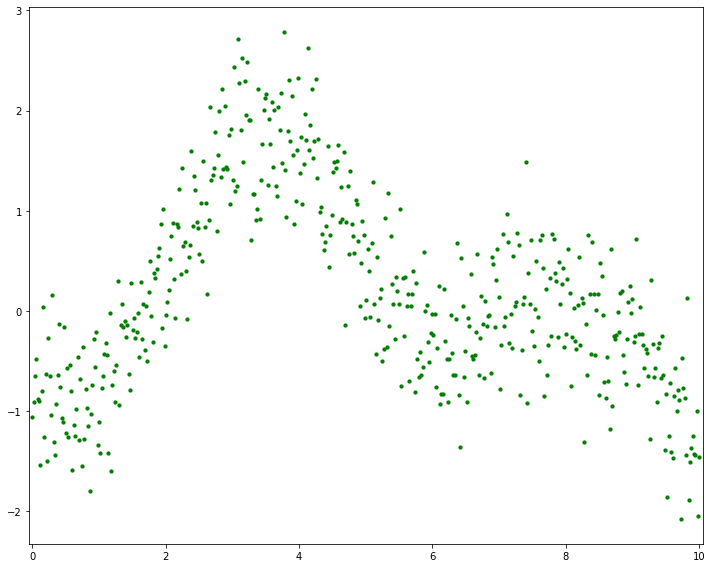

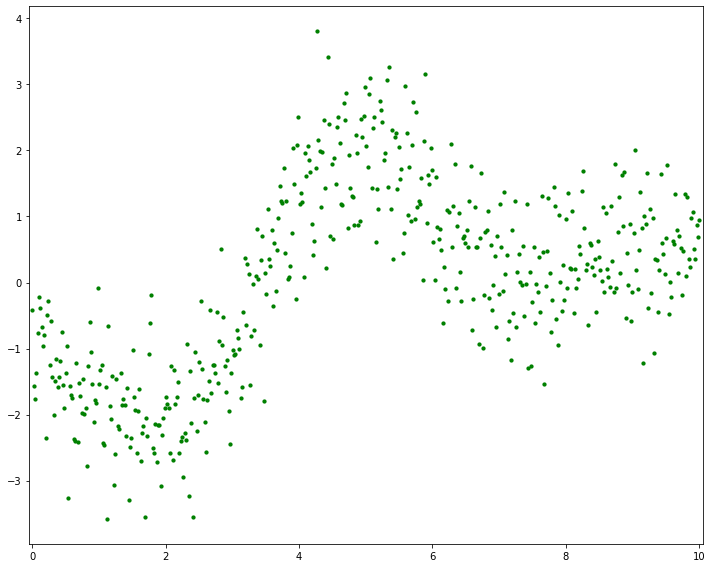

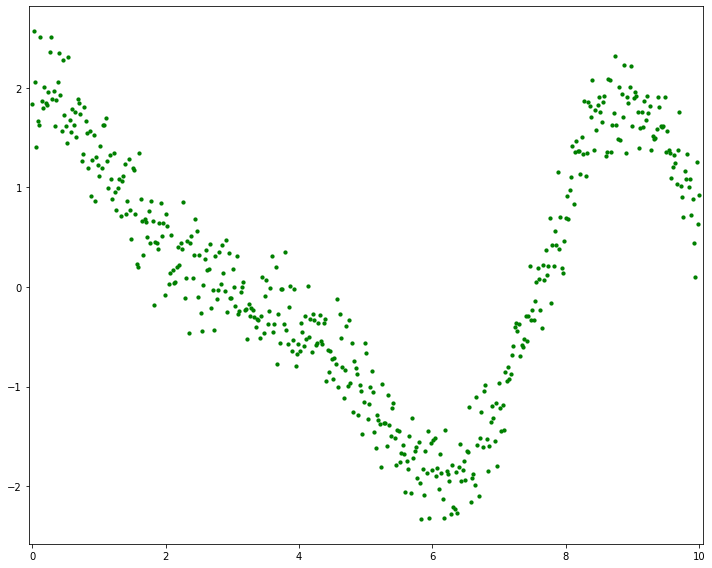

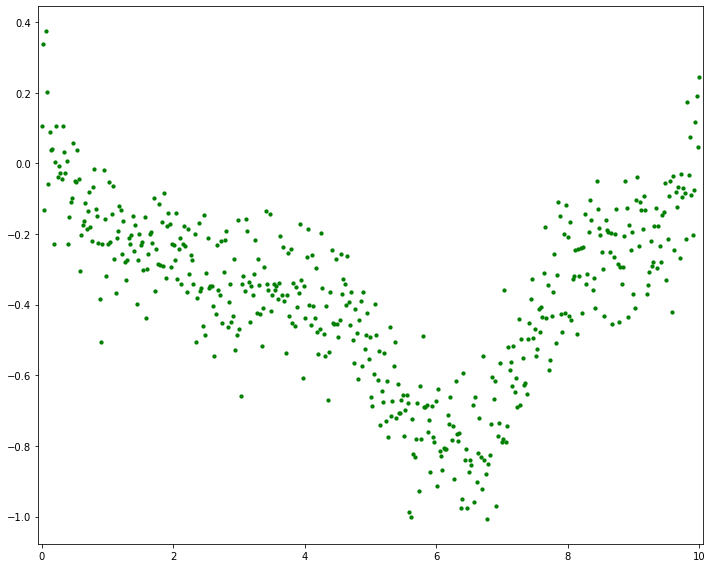

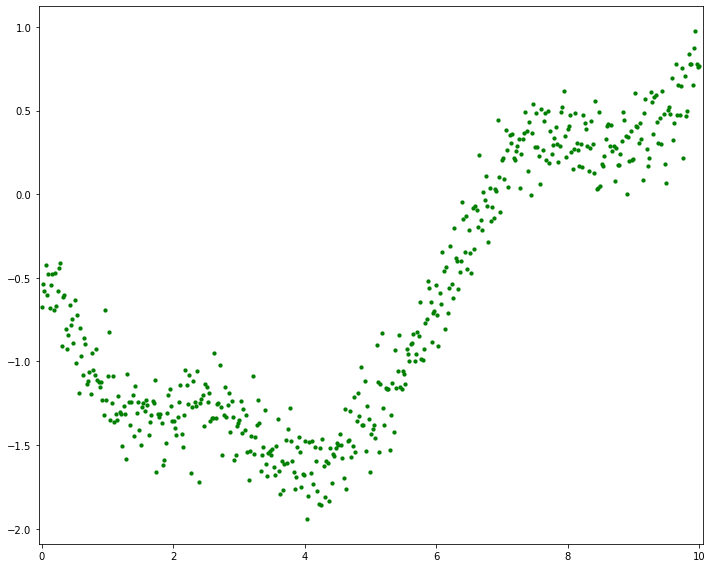

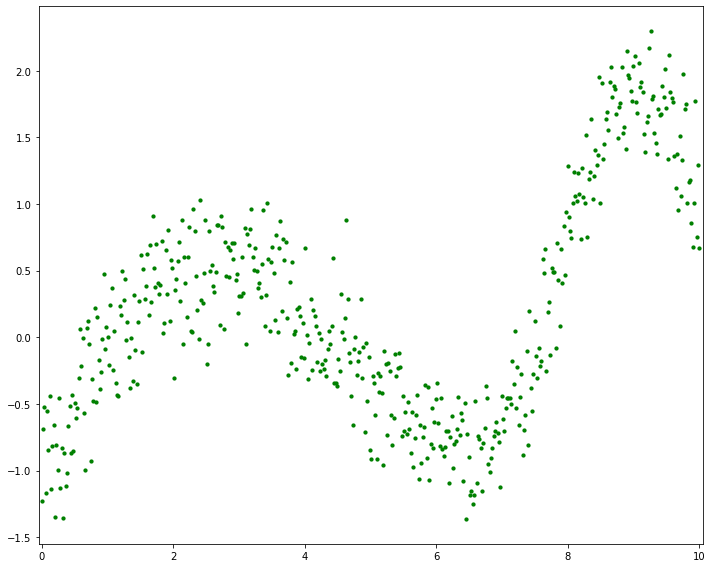

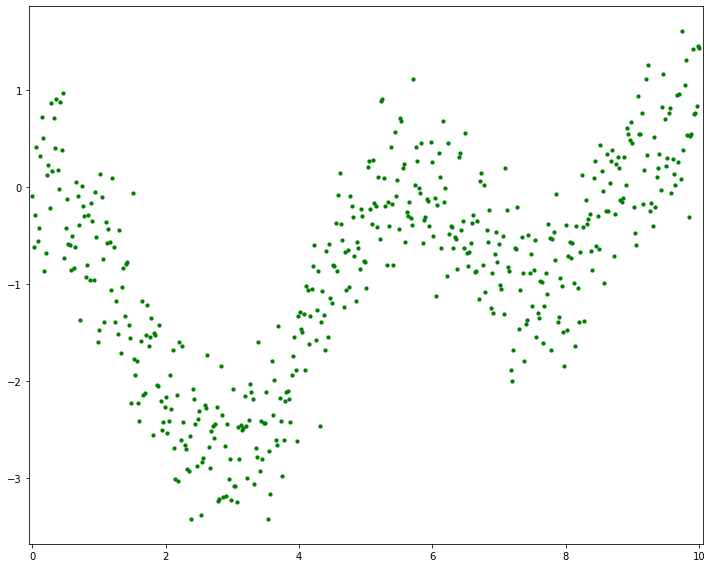

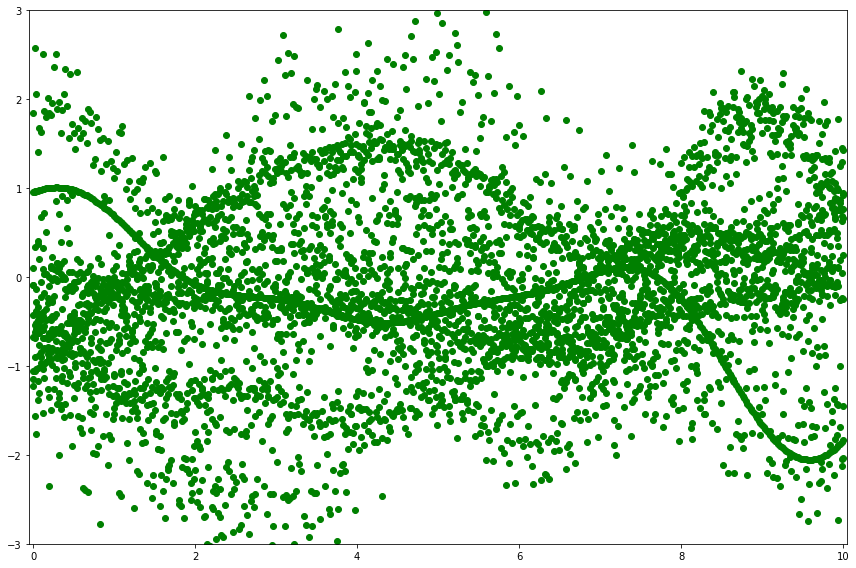

In [4]:
cov = SquaredExponential(2)
M = cov.f_mat(xs)
N = 6
ys_list = []

np.random.seed(12)
for i in range(10):
    fig, ax = plt.subplots()
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    epsilon = np.random.uniform(0, abs(.2*(max(ys) - min(ys))))
    epsilon = 1e-3 if i ==0 else epsilon
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(10,8)
    fig.set_tight_layout(True)
    figname = '/tmp/gp-se-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    print(epsilon)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.scatter(xs, ys, color='green', linewidth=1)
    ax.set_xlim([-.05, 10.05])
    ax.set_ylim([-3, 3])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
    fig.set_tight_layout(True)
figname = '/tmp/gp-se.png'
fig.savefig(figname, dpi=200)

for ys in ys_list:
    print(['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])

<ipython-input-5-80507760b864>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


['-0.15', '-0.12', '13.46', '13.63']
['-0.76', '0.30', '13.68', '13.81']
['-0.20', '-0.16', '20.20', '20.18']
['-0.15', '-0.20', '20.05', '19.97']
['0.03', '0.03', '0.70', '0.64']
['0.18', '0.05', '0.68', '0.50']
['-0.16', '-0.13', '11.12', '11.21']
['0.21', '0.33', '11.30', '10.87']
['0.05', '0.04', '-7.75', '-7.81']
['-0.38', '0.07', '-7.75', '-7.97']
['-0.07', '-0.05', '5.53', '5.53']
['-0.14', '-0.08', '5.68', '5.71']
['-0.08', '-0.06', '4.59', '4.65']
['-0.15', '-0.05', '4.53', '4.68']
['0.06', '0.05', '-2.13', '-2.20']
['-0.07', '-0.04', '-1.81', '-2.13']
['-0.01', '-0.01', '1.14', '0.91']
['-0.04', '0.11', '1.45', '0.72']
['-0.11', '-0.09', '11.09', '11.08']
['-0.20', '-0.13', '11.02', '11.12']
['-0.16', '-0.13', '15.59', '15.77']
['-0.20', '0.08', '15.59', '15.97']
['-0.02', '-0.02', '1.46', '1.42']
['-0.02', '-0.01', '1.47', '1.42']
['-0.04', '-0.03', '4.33', '4.21']
['0.00', '-0.06', '4.41', '4.26']
['0.02', '0.02', '-1.25', '-1.29']
['-0.06', '-0.01', '-1.20', '-1.35']
['0.0

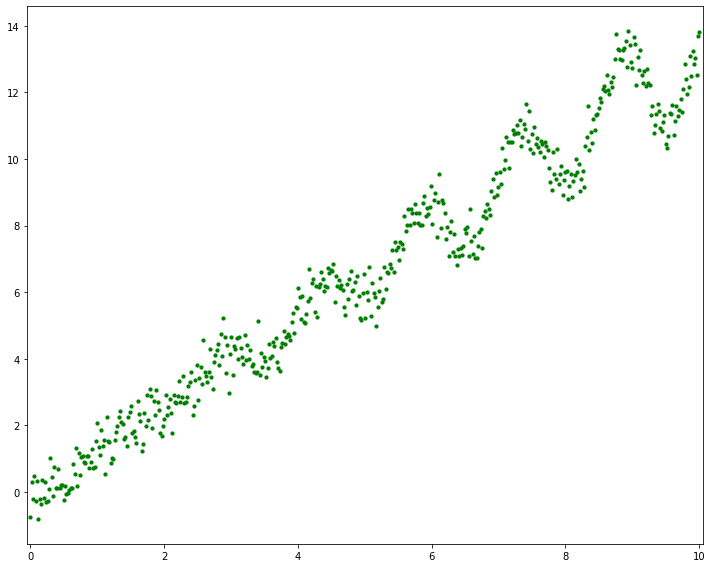

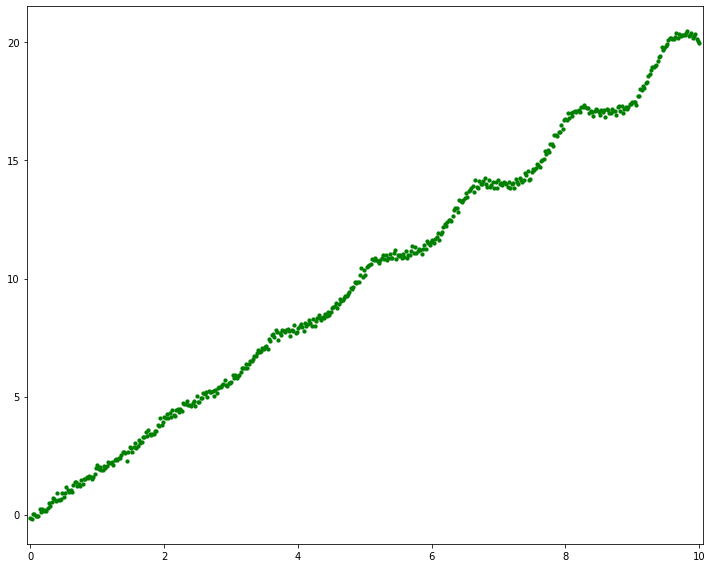

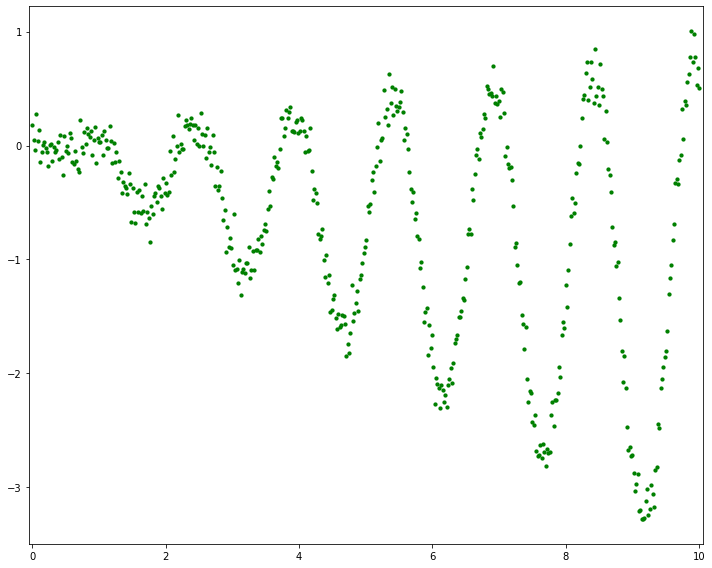

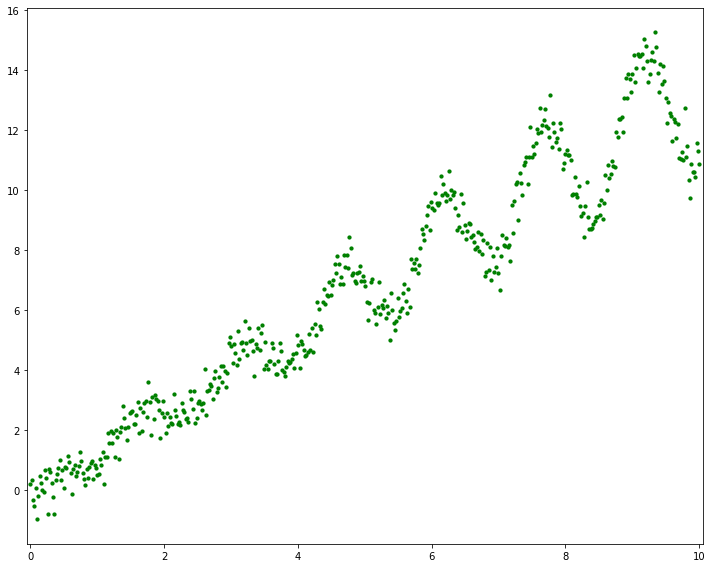

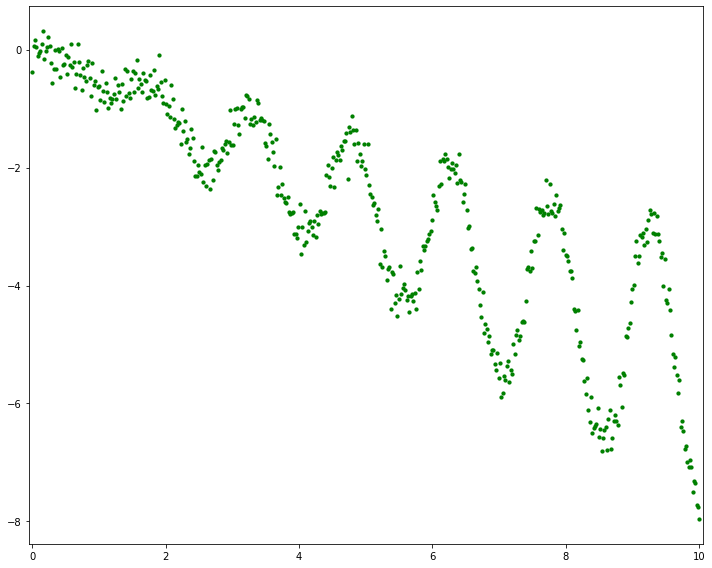

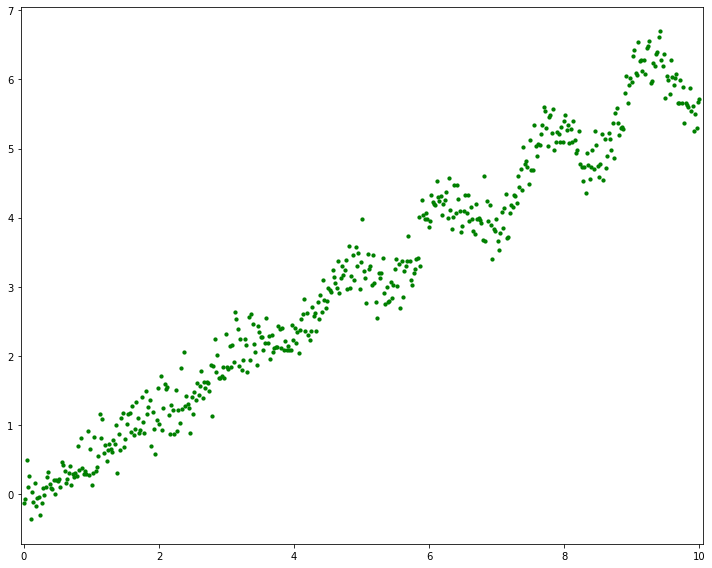

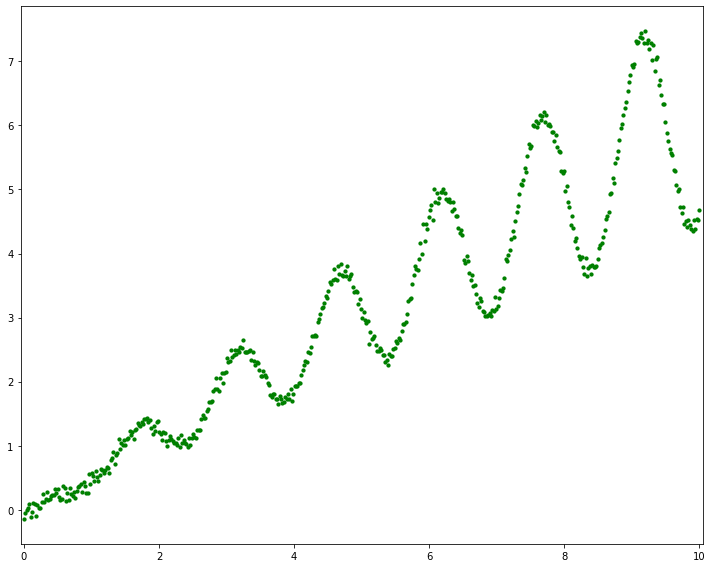

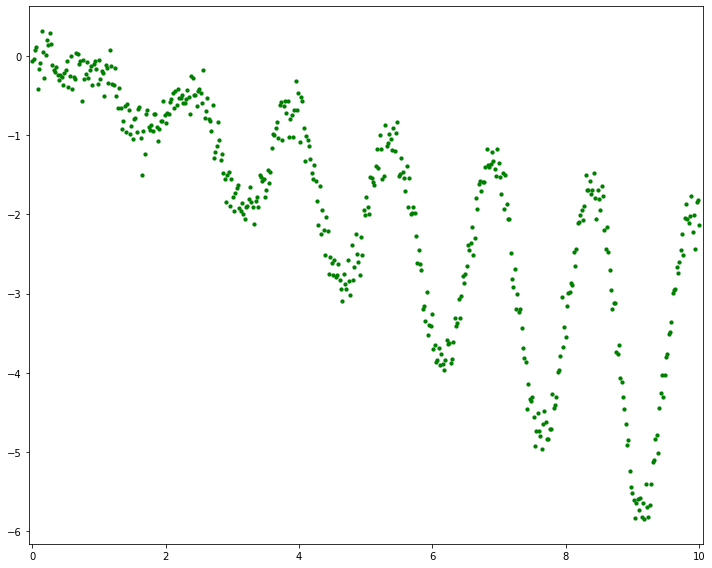

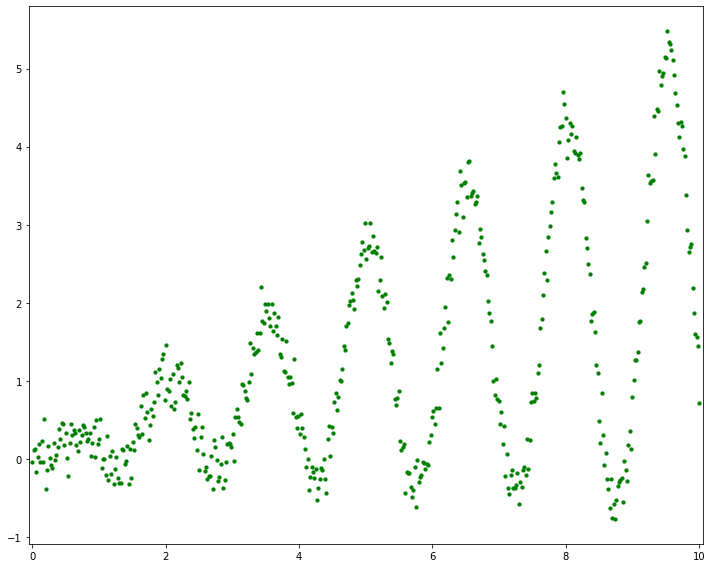

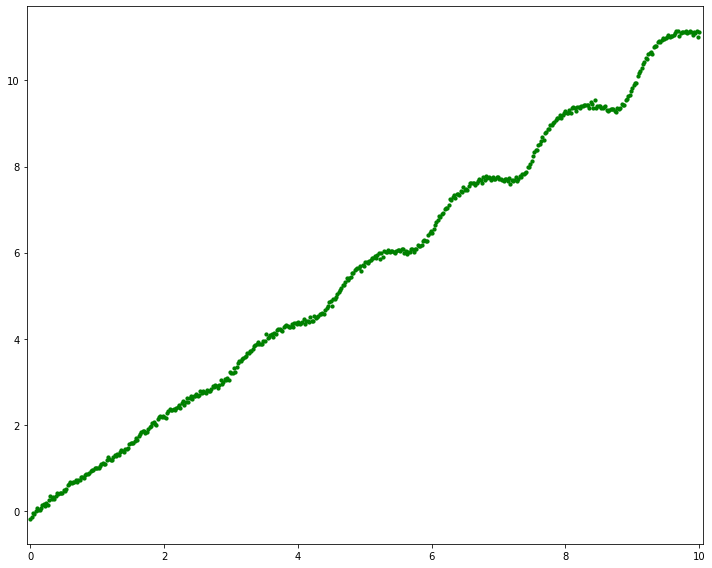

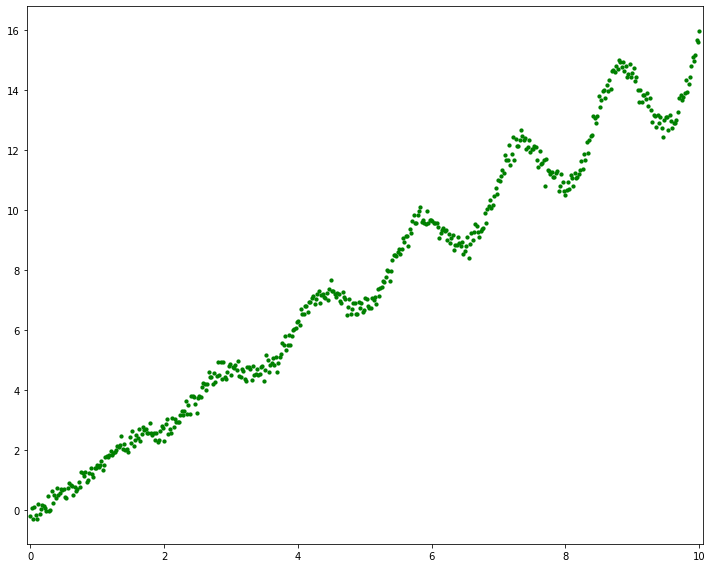

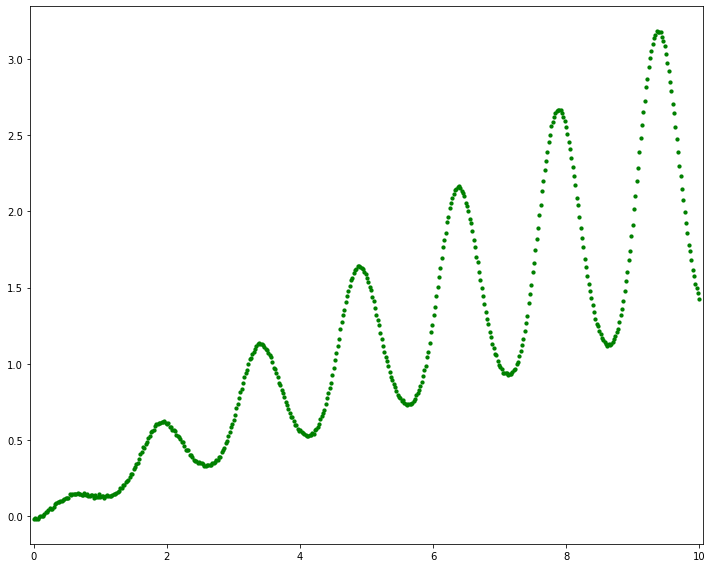

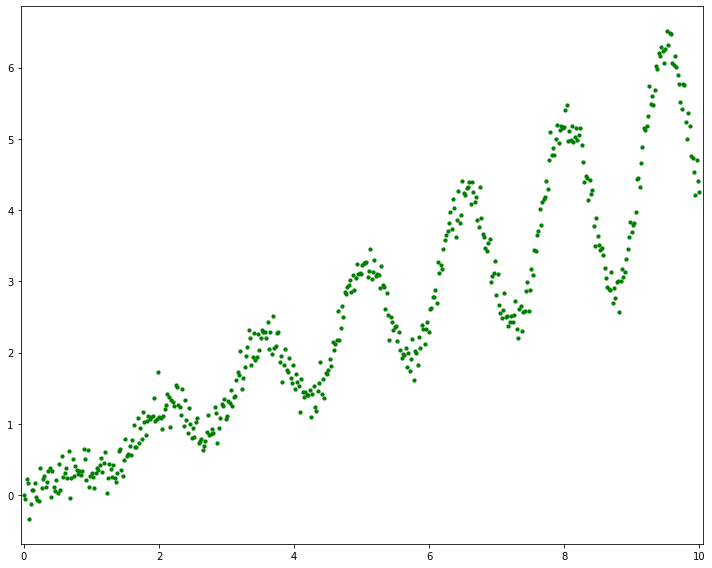

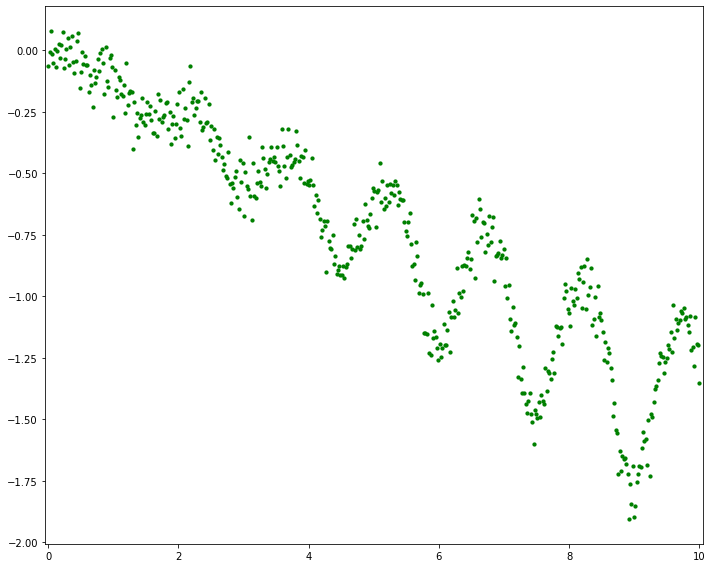

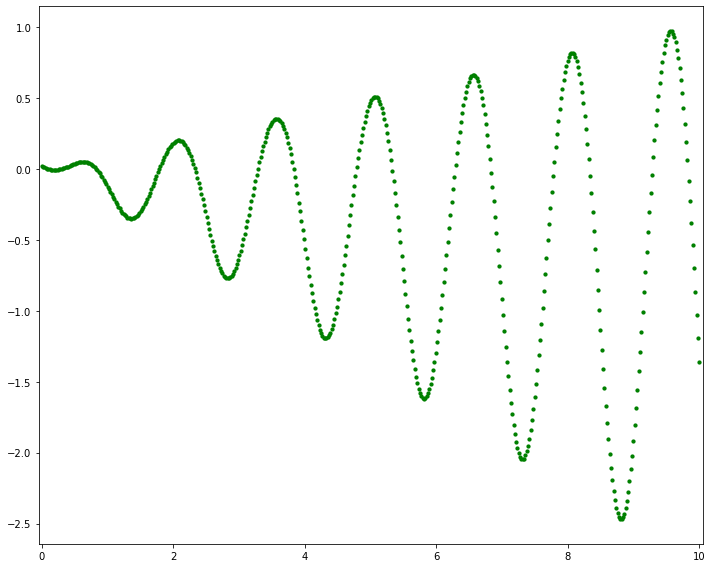

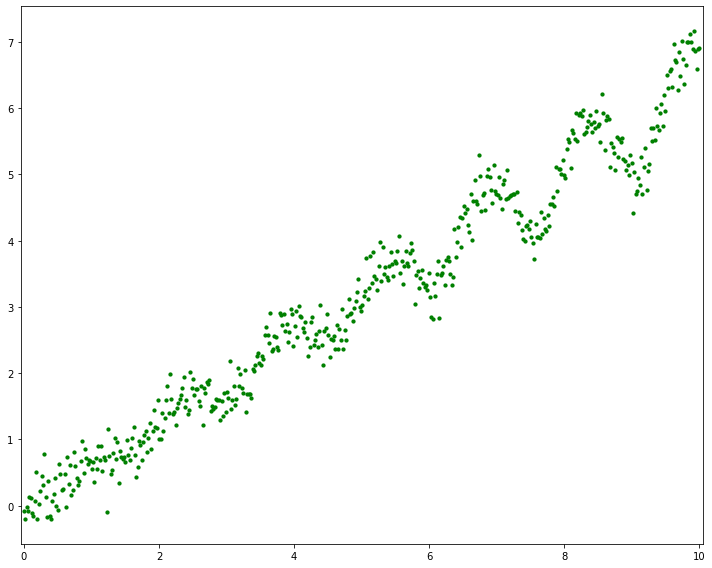

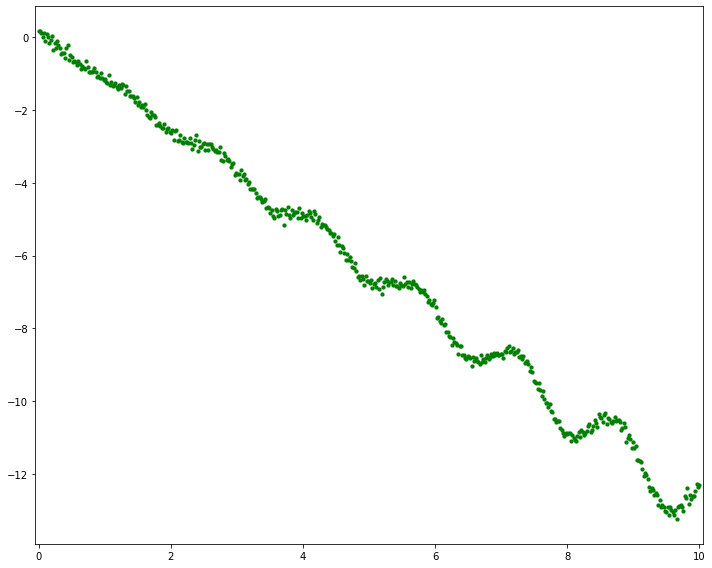

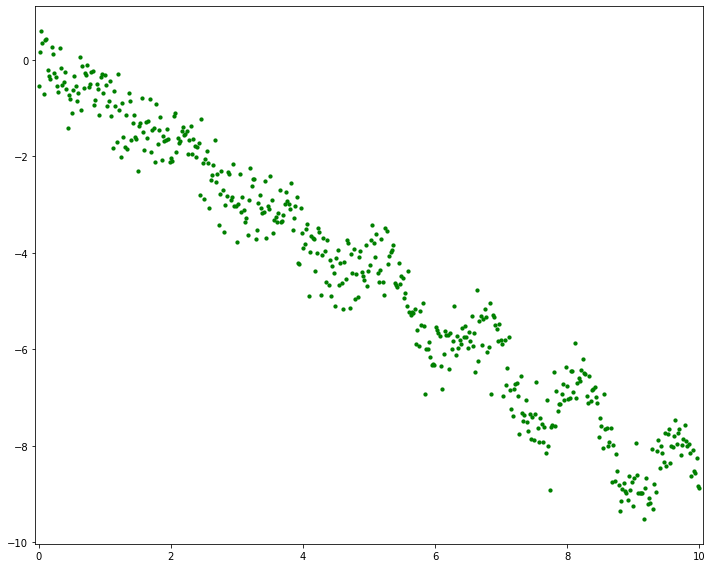

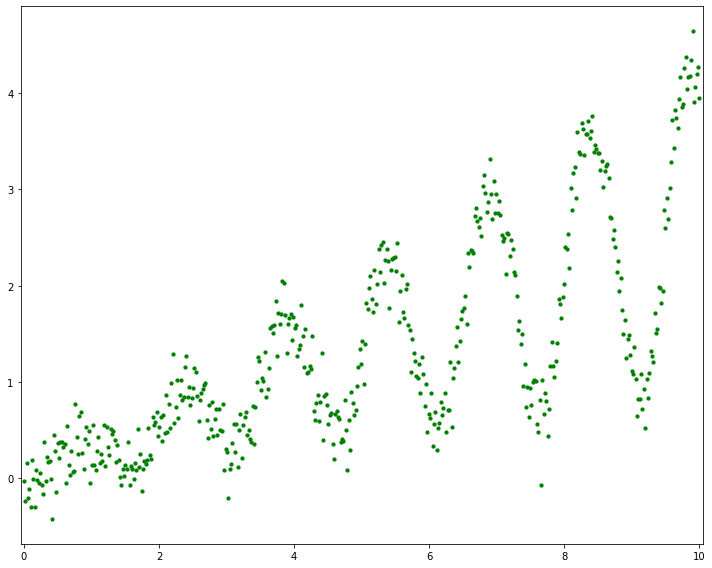

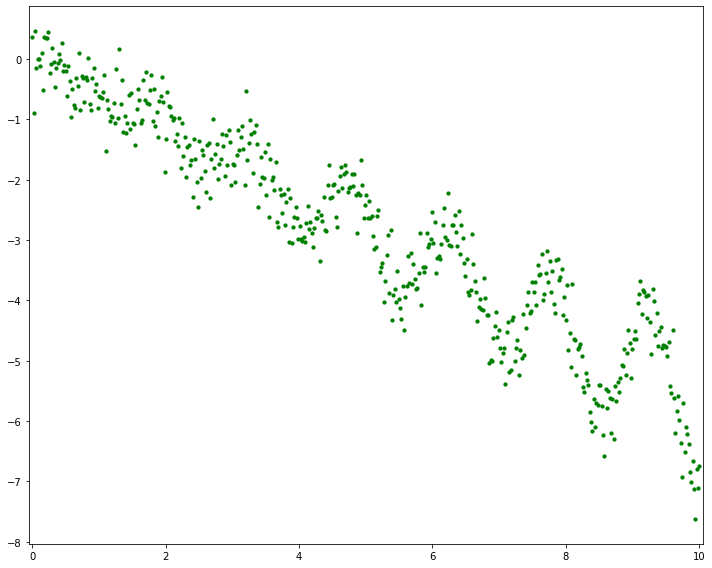

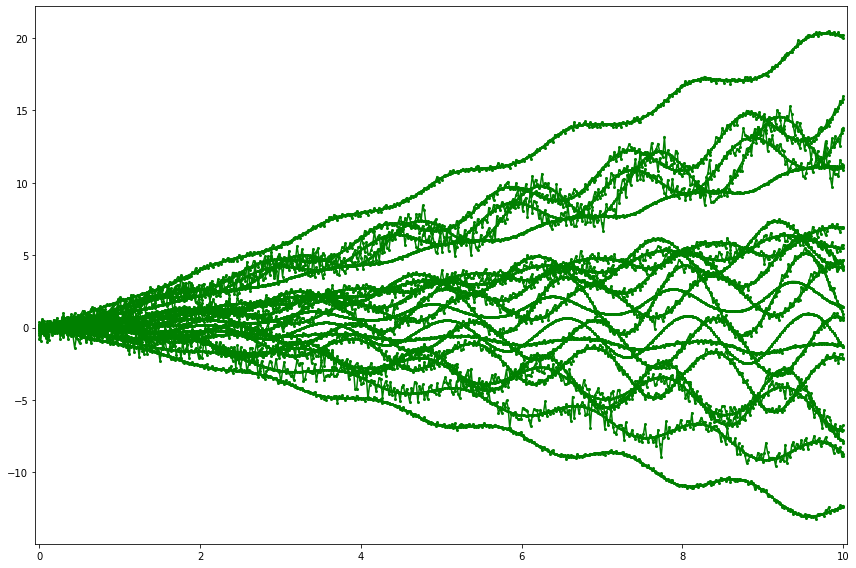

In [5]:
cov = Times(Linear(0.1), Periodic(50, 3))
M = cov.f_mat(xs)
N = 20
ys_list = []

np.random.seed(10)
for i in range(N):
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    ys_list.append(ys) 
    fig, ax = plt.subplots()
    epsilon = np.random.uniform(0, abs(.05*(max(ys) - min(ys))))
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(10, 8)
    fig.set_tight_layout(True)
    figname = '/tmp/gp-per-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.plot(xs, ys, color='green', linewidth=1.5, marker='o', ms=2)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
figname = '/tmp/gp-per.png'
fig.savefig(figname, dpi=200)

for ys in ys_list:
    print(['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])

<ipython-input-6-e3e386e57639>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


['-0.52', '-0.54', '0.89', '0.82']
['-0.55', '-0.48', '0.80', '0.84']
['-0.00', '-0.26', '-1.33', '-1.32']
['0.00', '-0.25', '-1.42', '-1.05']
['0.01', '-0.15', '-0.22', '-0.23']
['0.01', '-0.15', '-0.22', '-0.23']
['-1.38', '-1.32', '-0.03', '0.00']
['-1.27', '-1.29', '0.00', '0.06']
['-4.27', '-4.28', '-1.49', '-1.51']
['-4.76', '-4.44', '-1.20', '-1.68']
['4.12', '4.09', '0.08', '0.07']
['4.64', '4.07', '-0.07', '-0.16']
['-1.74', '-1.58', '1.13', '1.15']
['-1.77', '-1.73', '1.13', '1.32']
['0.62', '0.65', '1.51', '1.50']
['0.57', '0.64', '1.55', '1.50']
['-0.87', '-0.64', '0.75', '0.75']
['-0.87', '-0.66', '0.75', '0.69']
['-0.07', '-0.06', '0.89', '0.89']
['-0.01', '-0.05', '0.91', '0.85']
['2.55', '2.59', '0.11', '0.11']
['2.44', '2.63', '0.10', '0.01']
['-0.24', '-0.45', '0.22', '0.24']
['-0.28', '-0.45', '0.25', '0.30']
['-1.95', '-1.68', '-0.72', '-0.75']
['-1.94', '-1.81', '-0.78', '-0.80']
['1.46', '1.73', '-0.73', '-0.74']
['1.40', '1.92', '-0.98', '-0.87']
['1.35', '1.54',

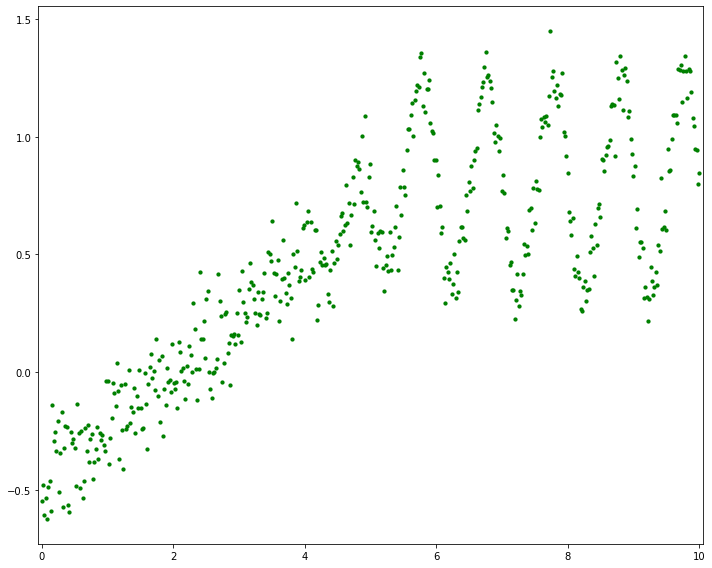

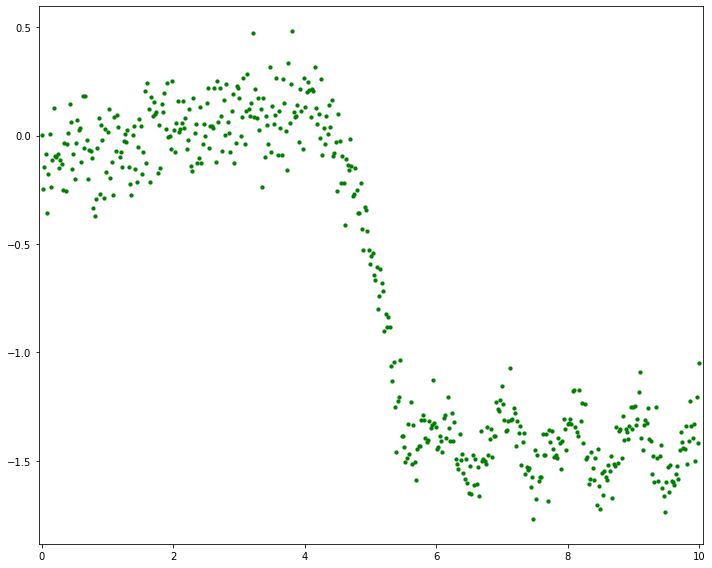

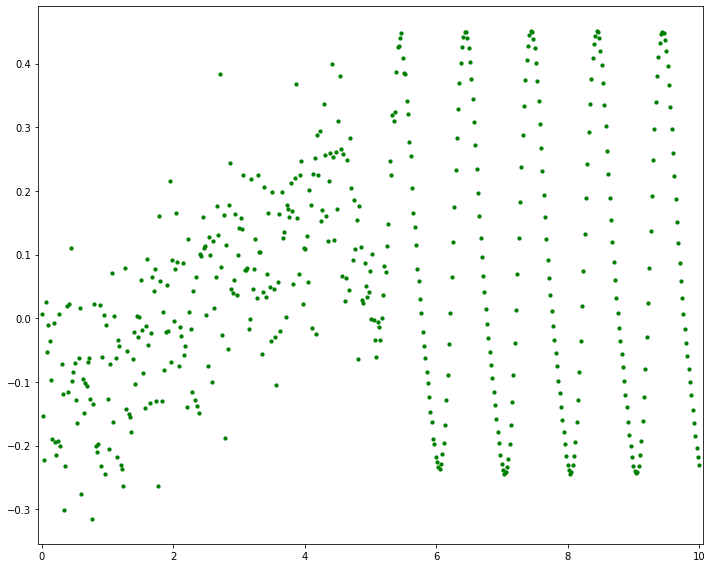

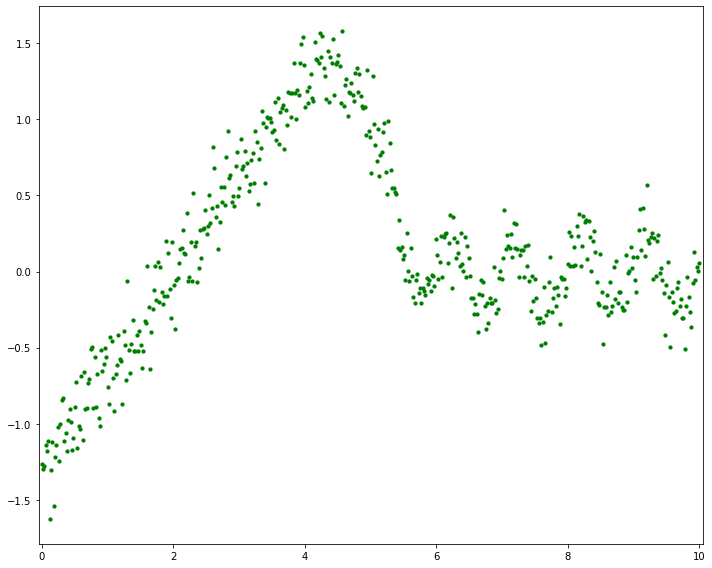

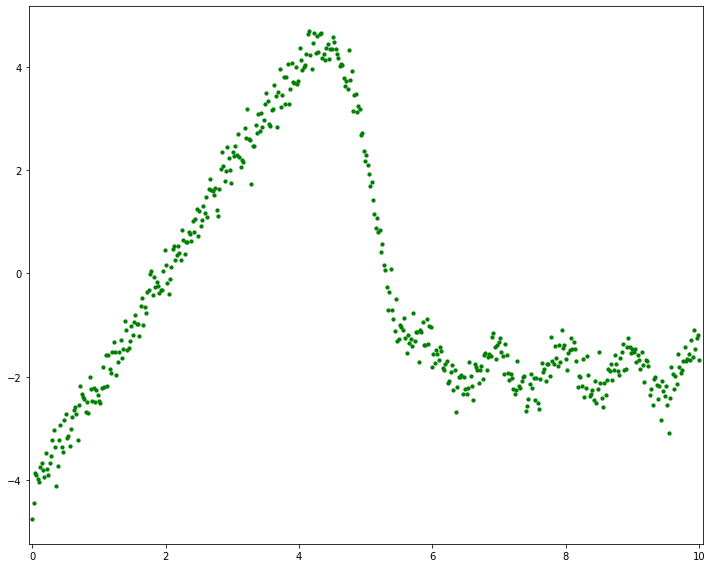

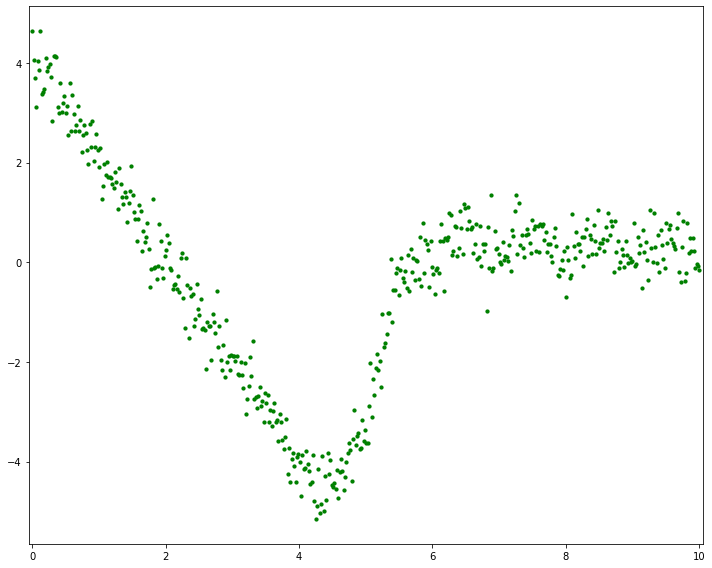

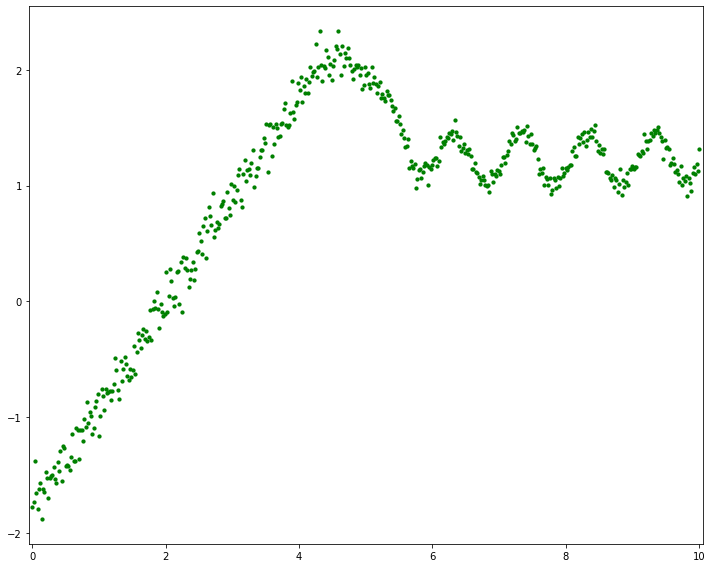

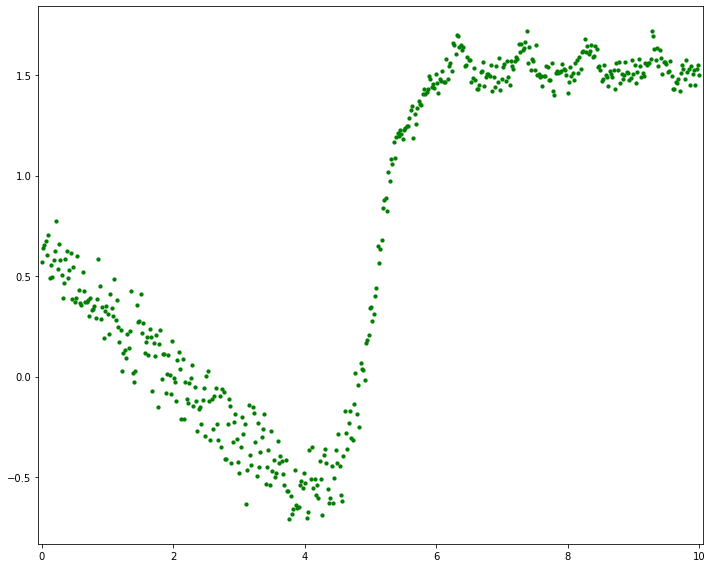

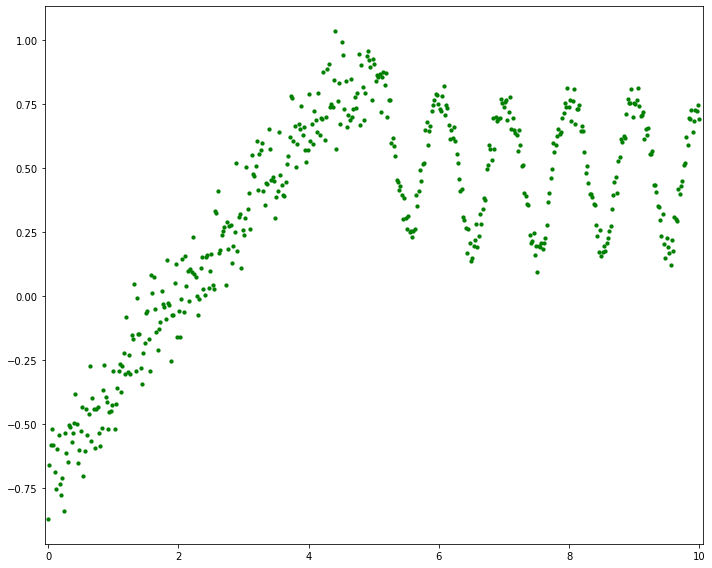

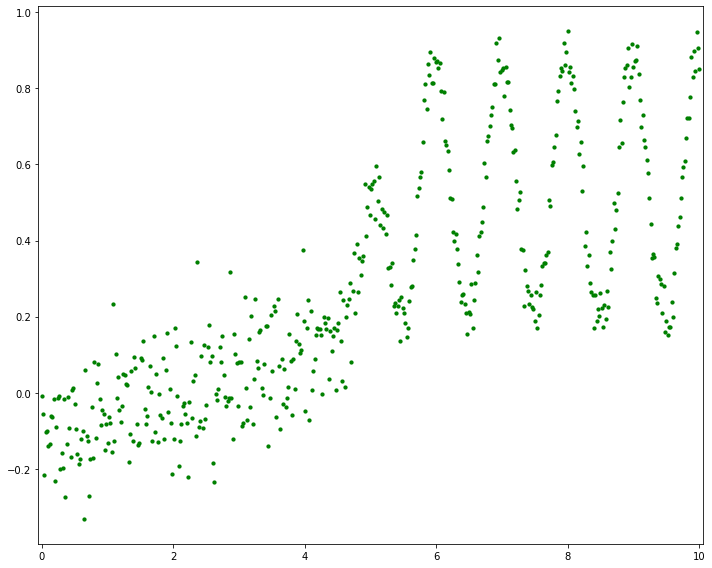

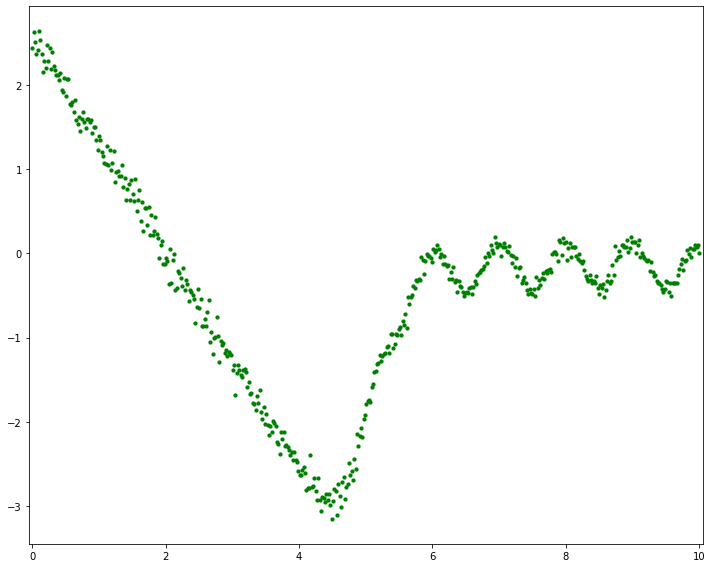

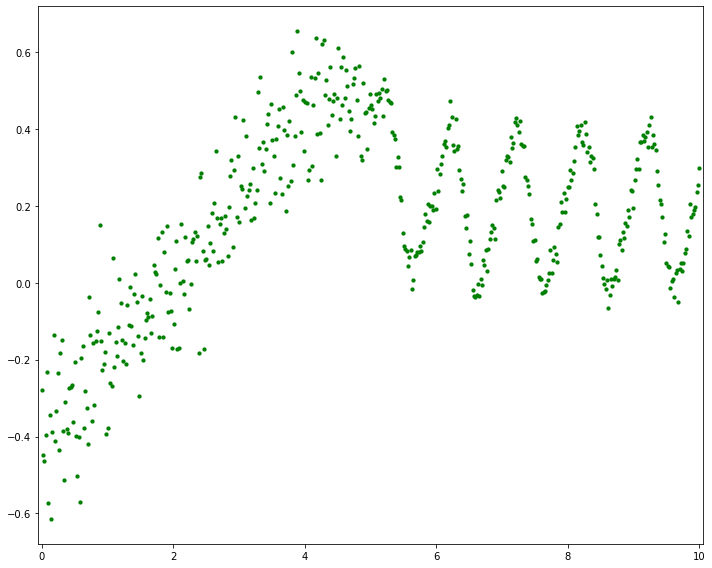

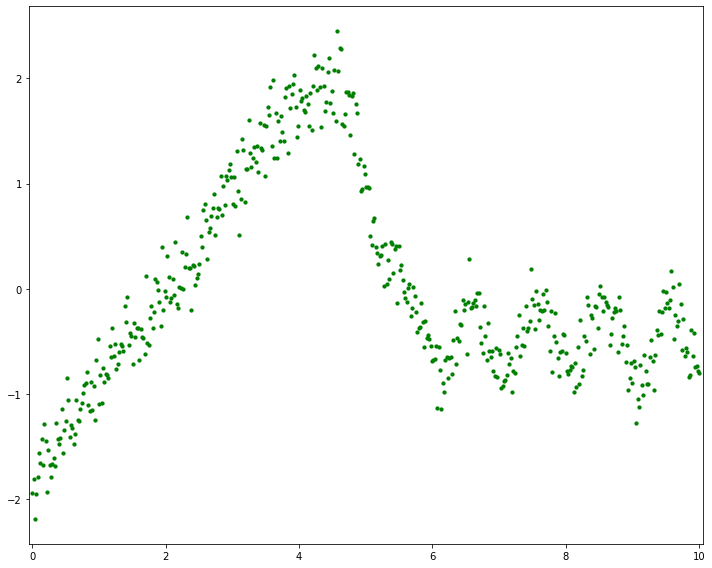

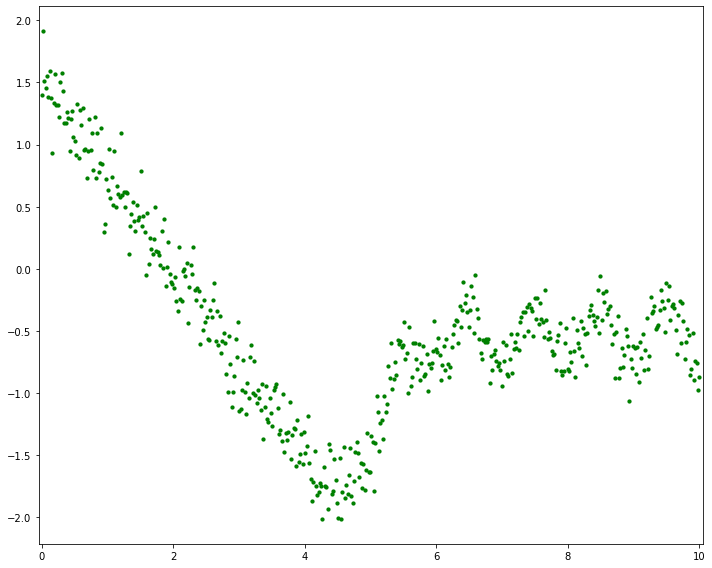

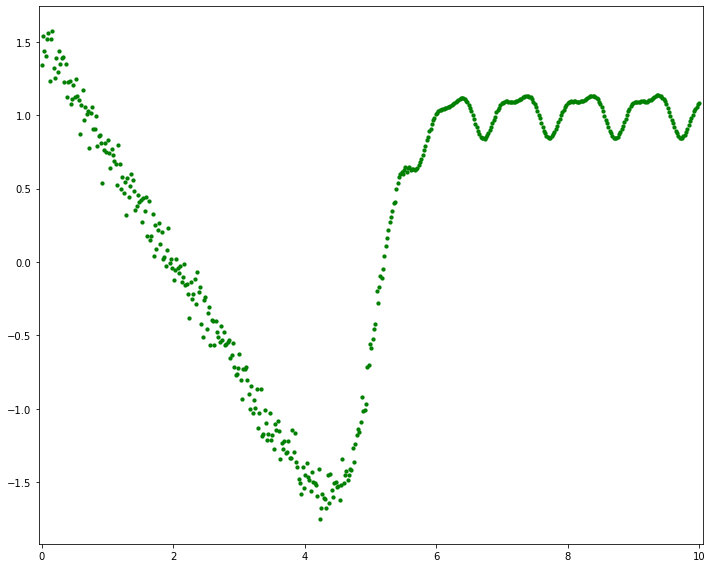

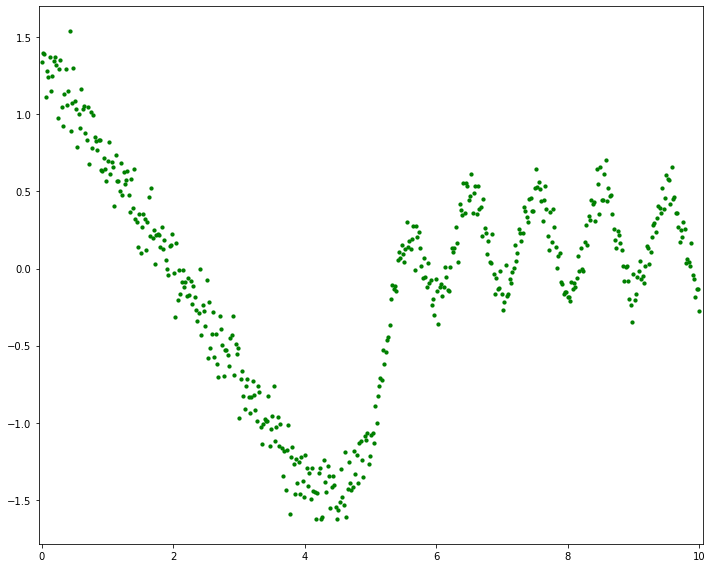

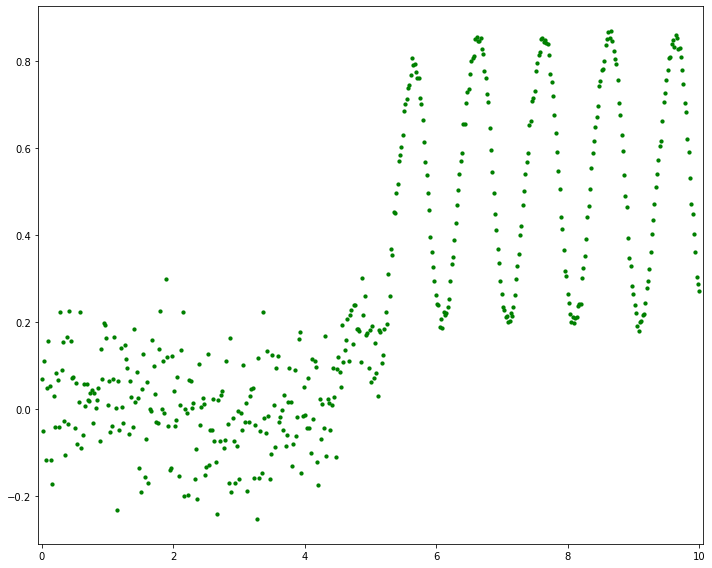

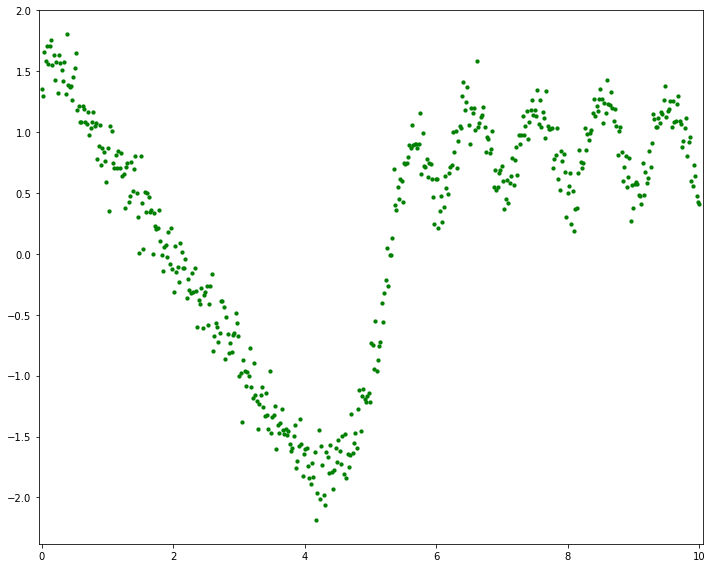

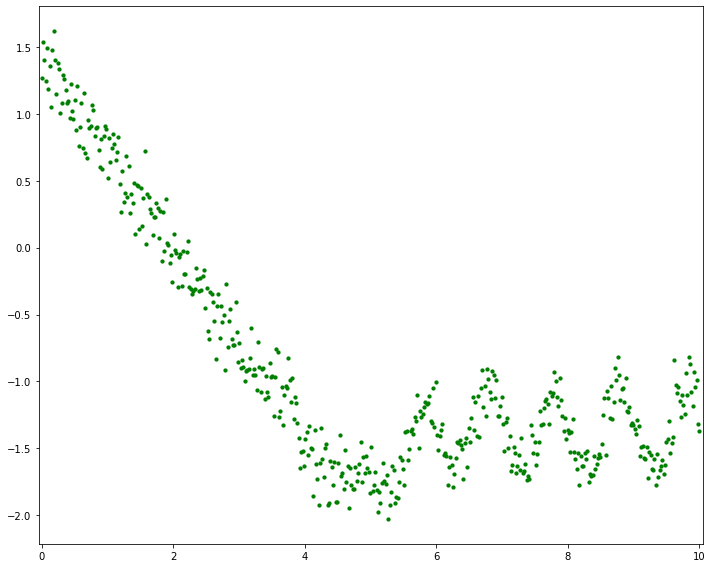

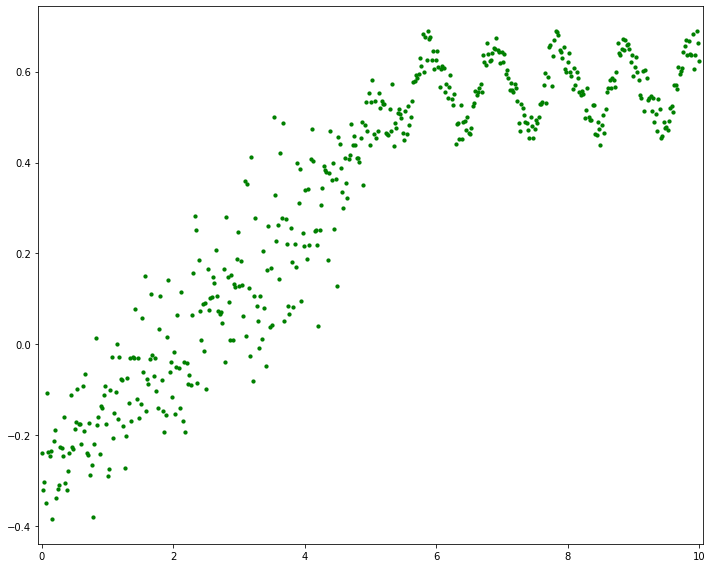

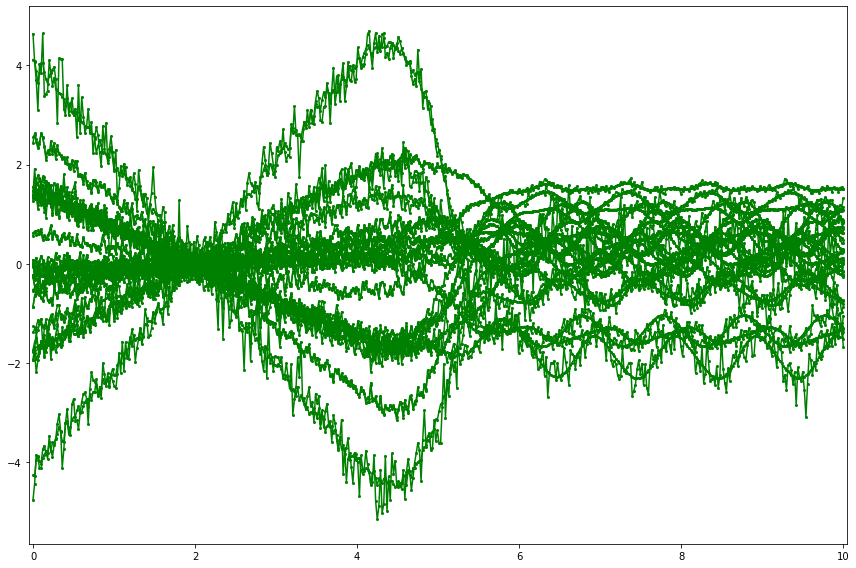

In [6]:
cov = ChangePoint(Plus(Linear(2), WhiteNoise(0.01)), Periodic(10, 2), 5, 0.5)
M = cov.f_mat(xs)
N = 20
ys_list = []

np.random.seed(110)
for i in range(N):
    ys = multivariate_normal.rvs(np.zeros(len(xs)), M, size=1)
    ys_list.append(ys)
    fig, ax = plt.subplots()
    epsilon = np.random.uniform(0, abs(.05*(max(ys) - min(ys))))
    noise = np.random.normal(0, epsilon, size=len(xs))
    ys_noisy = ys + noise
    ys_list.append(ys_noisy)
    ax.scatter(xs, ys_noisy, color='green', linewidth=2, marker='o', s=5)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(10, 8)
    figname = '/tmp/gp-cp-%02d.png' % (i,)
    fig.savefig(figname, dpi=200)
    
fig, ax = plt.subplots()
for ys in ys_list:
    ax.plot(xs, ys, color='green', linewidth=1.5, marker='o', ms=2)
    ax.set_xlim([-.05, 10.05])
    fig.set_tight_layout(True)
    fig.set_size_inches(12, 8)
figname = '/tmp/gp-cp.png'
fig.savefig(figname, dpi=200)

for ys in ys_list:
    print(['%1.2f' % (x,) for x in [ys[0], ys[1], ys[-2], ys[-1]]])